<a href="https://colab.research.google.com/github/armelyara/drgreen/blob/claude/drgreen-v2-01TfLAqRxjEF2BkLLt72vJrL/drgreen_v5_optimized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌿 Dr Green V5 - Optimized for Small Datasets

**Best approach for ~1000 images: Simple architecture, strong regularization**

### Why V5 is different:
- **Lighter model**: EfficientNetB0 (4M params vs 12M for B3)
- **No fine-tuning**: Frozen base only (prevents overfitting)
- **Strong augmentation**: Aggressive data augmentation
- **Label smoothing**: Better generalization
- **Cosine decay**: Optimal learning rate schedule

### Target: >85% accuracy with <5% overfitting gap

### Plant Classes:
1. Artemisia (Armoise) - Antimalarial
2. Carica (Papaya) - Digestive aid
3. Goyavier (Guava) - Antiseptic
4. Kinkeliba - Detoxifying

## 1. Setup & Imports

In [1]:
# Install gdown for dataset download
!pip install -q gdown

# Core imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import json
from datetime import datetime
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import zipfile
import os
import gdown

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")

# Check GPU
if len(tf.config.list_physical_devices('GPU')) > 0:
    print("✅ GPU detected - training will be fast!")
else:
    print("⚠️ No GPU - training will be slow. Enable GPU in Runtime > Change runtime type")

TensorFlow version: 2.19.0
GPU available: True
✅ GPU detected - training will be fast!


In [2]:
# Download dataset from Google Drive
file_id = '1zI5KfTtuV0BlBQnNDNq4tBJuEkxLZZBD'
url = f'https://drive.google.com/uc?id={file_id}'
output = '/content/drgreen.zip'

print("📥 Downloading dataset from Google Drive...")
try:
    gdown.download(url, output, quiet=False)
    print("✓ Dataset downloaded!")

    # Extract
    print("\n📂 Extracting...")
    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall('/content')
    print("✓ Dataset extracted!")
except:
    print("\n⚠️ Auto-download failed. Please upload manually:")
    print("from google.colab import files")
    print("uploaded = files.upload()")

📥 Downloading dataset from Google Drive...


Downloading...
From (original): https://drive.google.com/uc?id=1zI5KfTtuV0BlBQnNDNq4tBJuEkxLZZBD
From (redirected): https://drive.google.com/uc?id=1zI5KfTtuV0BlBQnNDNq4tBJuEkxLZZBD&confirm=t&uuid=162c9d5e-f151-4971-adc6-c51f50bce905
To: /content/drgreen.zip
100%|██████████| 232M/232M [00:03<00:00, 72.8MB/s]


✓ Dataset downloaded!

📂 Extracting...
✓ Dataset extracted!


## 2. Configuration (Optimized for Small Dataset)

In [3]:
# V5 Configuration - Optimized for ~1000 images
CONFIG = {
    # Paths
    'data_dir': 'rename',
    'model_save_dir': 'models',

    # Image parameters
    'img_height': 224,  # Standard size for EfficientNetB0
    'img_width': 224,
    'batch_size': 32,

    # Training parameters - SINGLE PHASE (no fine-tuning)
    'epochs': 50,
    'initial_lr': 0.001,

    'validation_split': 0.2,
    'seed': 42,

    # Model parameters
    'base_model': 'EfficientNetB0',  # Lighter than B3
    'dropout_rate': 0.5,
    'num_classes': 4,
    'dense_units': 128,  # Smaller than V4

    # Regularization
    'l2_reg': 0.01,
    'label_smoothing': 0.1,  # Helps generalization

    # Callbacks
    'early_stopping_patience': 10,
    'reduce_lr_patience': 5,
    'reduce_lr_factor': 0.5,
    'min_lr': 1e-7,
}

PLANT_CLASSES = ['artemisia', 'carica', 'goyavier', 'kinkeliba']
Path(CONFIG['model_save_dir']).mkdir(exist_ok=True)

print("\n" + "="*60)
print("🌿 DR GREEN V5 - OPTIMIZED FOR SMALL DATASETS")
print("="*60)
print(f"\nBase Model: {CONFIG['base_model']} (FROZEN - no fine-tuning)")
print(f"Image Size: {CONFIG['img_height']}x{CONFIG['img_width']}")
print(f"Batch Size: {CONFIG['batch_size']}")
print(f"Epochs: {CONFIG['epochs']}")
print(f"Learning Rate: {CONFIG['initial_lr']}")
print(f"\nRegularization:")
print(f"  - Dropout: {CONFIG['dropout_rate']}")
print(f"  - L2: {CONFIG['l2_reg']}")
print(f"  - Label Smoothing: {CONFIG['label_smoothing']}")
print("\n✅ Single-phase training (frozen base)")
print("✅ Strong data augmentation")
print("✅ Cosine decay learning rate")


🌿 DR GREEN V5 - OPTIMIZED FOR SMALL DATASETS

Base Model: EfficientNetB0 (FROZEN - no fine-tuning)
Image Size: 224x224
Batch Size: 32
Epochs: 50
Learning Rate: 0.001

Regularization:
  - Dropout: 0.5
  - L2: 0.01
  - Label Smoothing: 0.1

✅ Single-phase training (frozen base)
✅ Strong data augmentation
✅ Cosine decay learning rate


## 3. Load Dataset

In [14]:
# Load dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    CONFIG['data_dir'],
    validation_split=CONFIG['validation_split'],
    subset="training",
    seed=CONFIG['seed'],
    image_size=(CONFIG['img_height'], CONFIG['img_width']),
    batch_size=CONFIG['batch_size'],
    label_mode='categorical' # Changed to categorical for one-hot encoding
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    CONFIG['data_dir'],
    validation_split=CONFIG['validation_split'],
    subset="validation",
    seed=CONFIG['seed'],
    image_size=(CONFIG['img_height'], CONFIG['img_width']),
    batch_size=CONFIG['batch_size'],
    label_mode='categorical' # Changed to categorical for one-hot encoding
)

class_names = train_ds.class_names
print(f"\n✅ Classes found: {class_names}")
print(f"Number of classes: {len(class_names)}")

Found 1168 files belonging to 4 classes.
Using 935 files for training.
Found 1168 files belonging to 4 classes.
Using 233 files for validation.

✅ Classes found: ['artemisia', 'carica', 'goyavier', 'kinkeliba']
Number of classes: 4


In [5]:
# Count samples per class
class_counts = {name: 0 for name in class_names}

for images, labels in train_ds:
    for label in labels.numpy():
        class_counts[class_names[label]] += 1

val_class_counts = {name: 0 for name in class_names}
for images, labels in val_ds:
    for label in labels.numpy():
        val_class_counts[class_names[label]] += 1

print("\n📊 Dataset Statistics:")
print("\nTraining set:")
total_train = sum(class_counts.values())
for class_name, count in class_counts.items():
    print(f"  {class_name}: {count} images ({count/total_train*100:.1f}%)")
print(f"  Total: {total_train}")

print("\nValidation set:")
total_val = sum(val_class_counts.values())
for class_name, count in val_class_counts.items():
    print(f"  {class_name}: {count} images ({count/total_val*100:.1f}%)")
print(f"  Total: {total_val}")

# Calculate class weights
total_samples = sum(class_counts.values())
class_weights = {}
for i, class_name in enumerate(class_names):
    class_weights[i] = total_samples / (len(class_names) * class_counts[class_name])

print("\n⚖️ Class weights (for imbalance):")
for i, weight in class_weights.items():
    print(f"  {class_names[i]}: {weight:.3f}")


📊 Dataset Statistics:

Training set:
  artemisia: 229 images (24.5%)
  carica: 293 images (31.3%)
  goyavier: 187 images (20.0%)
  kinkeliba: 226 images (24.2%)
  Total: 935

Validation set:
  artemisia: 47 images (20.2%)
  carica: 64 images (27.5%)
  goyavier: 54 images (23.2%)
  kinkeliba: 68 images (29.2%)
  Total: 233

⚖️ Class weights (for imbalance):
  artemisia: 1.021
  carica: 0.798
  goyavier: 1.250
  kinkeliba: 1.034


## 4. Strong Data Augmentation

In [6]:
# Strong data augmentation for small dataset
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.3),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomBrightness(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
], name="strong_augmentation")

# Preprocessing for EfficientNet
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

print("✅ Strong data augmentation configured:")
for layer in data_augmentation.layers:
    print(f"  - {layer.name}")

✅ Strong data augmentation configured:
  - random_flip
  - random_rotation
  - random_zoom
  - random_brightness
  - random_contrast
  - random_translation


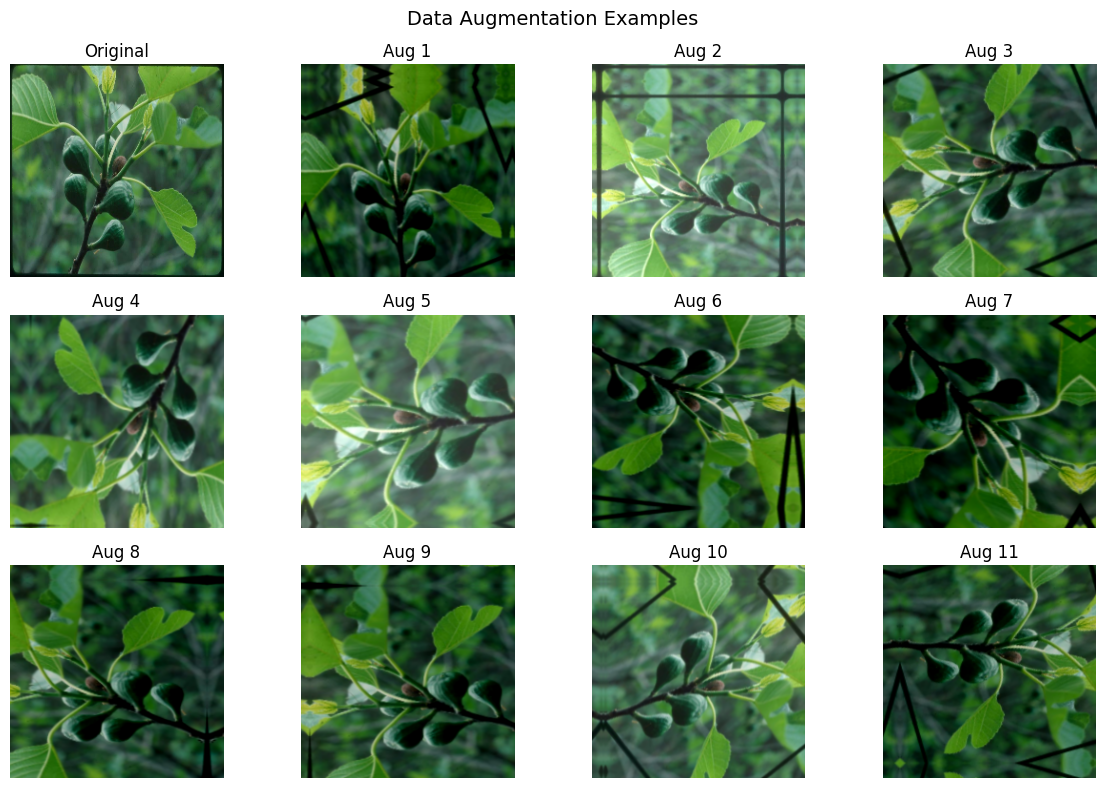

In [7]:
# Visualize augmentation
plt.figure(figsize=(12, 8))
for images, labels in train_ds.take(1):
    image = images[0]
    plt.subplot(3, 4, 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("Original")
    plt.axis("off")

    for i in range(11):
        augmented = data_augmentation(tf.expand_dims(image, 0), training=True)
        plt.subplot(3, 4, i + 2)
        plt.imshow(augmented[0].numpy().astype("uint8"))
        plt.title(f"Aug {i+1}")
        plt.axis("off")

plt.suptitle("Data Augmentation Examples", fontsize=14)
plt.tight_layout()
plt.show()

## 5. Prepare Data Pipeline

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

# Training: augmentation + preprocessing
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=AUTOTUNE
)
train_ds = train_ds.map(
    lambda x, y: (preprocess_input(x), y),
    num_parallel_calls=AUTOTUNE
)

# Validation: only preprocessing
val_ds = val_ds.map(
    lambda x, y: (preprocess_input(x), y),
    num_parallel_calls=AUTOTUNE
)

# Optimize pipeline
train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

print("✅ Data pipeline optimized")

✅ Data pipeline optimized


## 6. Build Model (Frozen Base - Optimal for Small Dataset)

In [9]:
def build_model():
    """
    Build EfficientNetB0 with FROZEN base
    Optimal for small datasets - prevents overfitting
    """
    # Input
    inputs = tf.keras.Input(shape=(CONFIG['img_height'], CONFIG['img_width'], 3))

    # Base model - FROZEN
    base_model = tf.keras.applications.EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_tensor=inputs,
        pooling='avg'
    )
    base_model.trainable = False  # IMPORTANT: Keep frozen!

    # Classification head with strong regularization
    x = base_model.output

    # Dropout
    x = tf.keras.layers.Dropout(CONFIG['dropout_rate'])(x)

    # Dense layer with L2 regularization
    x = tf.keras.layers.Dense(
        CONFIG['dense_units'],
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(CONFIG['l2_reg'])
    )(x)

    # Batch normalization
    x = tf.keras.layers.BatchNormalization()(x)

    # Another dropout
    x = tf.keras.layers.Dropout(CONFIG['dropout_rate'] / 2)(x)

    # Output
    outputs = tf.keras.layers.Dense(
        CONFIG['num_classes'],
        activation='softmax',
        kernel_regularizer=tf.keras.regularizers.l2(CONFIG['l2_reg'])
    )(x)

    model = tf.keras.Model(inputs, outputs, name='DrGreen_V5_Optimized')

    return model, base_model

# Build model
model, base_model = build_model()

print("\n" + "="*60)
print("MODEL ARCHITECTURE")
print("="*60)
print(f"Base: {CONFIG['base_model']} (FROZEN)")
print(f"Base trainable: {base_model.trainable}")
print(f"Total parameters: {model.count_params():,}")
trainable = sum([tf.size(v).numpy() for v in model.trainable_variables])
print(f"Trainable parameters: {trainable:,}")
print(f"Non-trainable: {model.count_params() - trainable:,}")

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

MODEL ARCHITECTURE
Base: EfficientNetB0 (FROZEN)
Base trainable: False
Total parameters: 4,214,567
Trainable parameters: 164,740
Non-trainable: 4,049,827


In [10]:
# Model summary
model.summary()

Model: "DrGreen_V5_Optimized"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,214,567 (16.08 MB)

 Trainable params: 164,740 (643.52 KB)

 Non-trainable params: 4,049,827 (15.45 MB)

## 7. Compile Model with Cosine Decay

In [15]:
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
total_steps = steps_per_epoch * CONFIG['epochs']

lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=CONFIG['initial_lr'],
    decay_steps=total_steps,
    alpha=0.01
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=CONFIG['label_smoothing']),
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='accuracy'), # Changed from SparseCategoricalAccuracy
        tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top2_accuracy') # Changed from SparseTopKCategoricalAccuracy
    ]
)

print("\n" + "="*60)
print("MODEL COMPILED")
print("="*60)
print(f"Optimizer: Adam with Cosine Decay")
print(f"Initial LR: {CONFIG['initial_lr']}")
print(f"Loss: CategoricalCrossentropy")
print(f"Label Smoothing: {CONFIG['label_smoothing']}")
print(f"Total steps: {total_steps}")


MODEL COMPILED
Optimizer: Adam with Cosine Decay
Initial LR: 0.001
Loss: CategoricalCrossentropy
Label Smoothing: 0.1
Total steps: 1500


In [17]:
print("\n" + "="*60)
print("🚀 STARTING TRAINING")
print("="*60)
print(f"Epochs: {CONFIG['epochs']}")
print(f"Batch size: {CONFIG['batch_size']}")
print(f"Training samples: ~{total_train}")
print(f"Validation samples: ~{total_val}")
print(f"Class weights: Enabled")
print("="*60 + "\n")

# Train!
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=CONFIG['epochs'],
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

print("\n" + "="*60)
print("✅ TRAINING COMPLETED")
print("="*60)


🚀 STARTING TRAINING
Epochs: 50
Batch size: 32
Training samples: ~935
Validation samples: ~233
Class weights: Enabled

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.4110 - loss: 4.0439 - top2_accuracy: 0.6419
Epoch 1: val_accuracy improved from -inf to 0.70386, saving model to models/best_model_v5.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.4145 - loss: 4.0344 - top2_accuracy: 0.6448 - val_accuracy: 0.7039 - val_loss: 3.1357 - val_top2_accuracy: 0.8712 - learning_rate: 9.9902e-04
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.6696 - loss: 3.1011 - top2_accuracy: 0.8835
Epoch 2: val_accuracy improved from 0.70386 to 0.72961, saving model to models/best_model_v5.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 250ms/step - accuracy: 0.6703 - loss: 3.0995 - top2_accuracy: 0.8837 - val_accuracy: 0.7296 - val_loss: 2.8383 - val_top2_accuracy: 0.8841 - learning_rate: 9.9610e-04
Epoch 3/50
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.7386 - l

In [18]:
callbacks = [
    # Early stopping
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=CONFIG['early_stopping_patience'],
        restore_best_weights=True,
        verbose=1
    ),

    # Reduce LR on plateau (backup to cosine decay)
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=CONFIG['reduce_lr_factor'],
        patience=CONFIG['reduce_lr_patience'],
        min_lr=CONFIG['min_lr'],
        verbose=1
    ),

    # Save best model
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f"{CONFIG['model_save_dir']}/best_model_v5.keras",
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),

    # CSV logger
    tf.keras.callbacks.CSVLogger(
        f"{CONFIG['model_save_dir']}/training_log_v5.csv"
    )
]

print("✅ Callbacks configured:")
for cb in callbacks:
    print(f"  - {cb.__class__.__name__}")

✅ Callbacks configured:
  - EarlyStopping
  - ReduceLROnPlateau
  - ModelCheckpoint
  - CSVLogger


## 8. Setup Callbacks

In [19]:
callbacks = [
    # Early stopping
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=CONFIG['early_stopping_patience'],
        restore_best_weights=True,
        verbose=1
    ),

    # Reduce LR on plateau (backup to cosine decay)
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=CONFIG['reduce_lr_factor'],
        patience=CONFIG['reduce_lr_patience'],
        min_lr=CONFIG['min_lr'],
        verbose=1
    ),

    # Save best model
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f"{CONFIG['model_save_dir']}/best_model_v5.keras",
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),

    # CSV logger
    tf.keras.callbacks.CSVLogger(
        f"{CONFIG['model_save_dir']}/training_log_v5.csv"
    )
]

print("✅ Callbacks configured:")
for cb in callbacks:
    print(f"  - {cb.__class__.__name__}")

✅ Callbacks configured:
  - EarlyStopping
  - ReduceLROnPlateau
  - ModelCheckpoint
  - CSVLogger


## 9. Train Model

In [20]:
print("\n" + "="*60)
print("🚀 STARTING TRAINING")
print("="*60)
print(f"Epochs: {CONFIG['epochs']}")
print(f"Batch size: {CONFIG['batch_size']}")
print(f"Training samples: ~{total_train}")
print(f"Validation samples: ~{total_val}")
print(f"Class weights: Enabled")
print("="*60 + "\n")

# Train!
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=CONFIG['epochs'],
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

print("\n" + "="*60)
print("✅ TRAINING COMPLETED")
print("="*60)


🚀 STARTING TRAINING
Epochs: 50
Batch size: 32
Training samples: ~935
Validation samples: ~233
Class weights: Enabled

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9352 - loss: 0.7699 - top2_accuracy: 0.9947
Epoch 1: val_accuracy improved from -inf to 0.76824, saving model to models/best_model_v5.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 227ms/step - accuracy: 0.9353 - loss: 0.7699 - top2_accuracy: 0.9946 - val_accuracy: 0.7682 - val_loss: 1.0169 - val_top2_accuracy: 0.9270 - learning_rate: 1.0000e-05
Epoch 2/50
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.9274 - loss: 0.7894 - top2_accuracy: 0.9815
Epoch 2: val_accuracy did not improve from 0.76824
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 282ms/step - accuracy: 0.9279 - loss: 0.7891 - top2_accuracy: 0.9816 - val_accuracy: 0.7682 - val_loss: 1.0157 - val_top2_accuracy: 0.9270 - learning_rate: 1.0000e-05
Epoch 3/50
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9172 - loss: 0.7862 - top2_accuracy: 0.9946
Epoch 3: v

## 10. Visualize Training Results

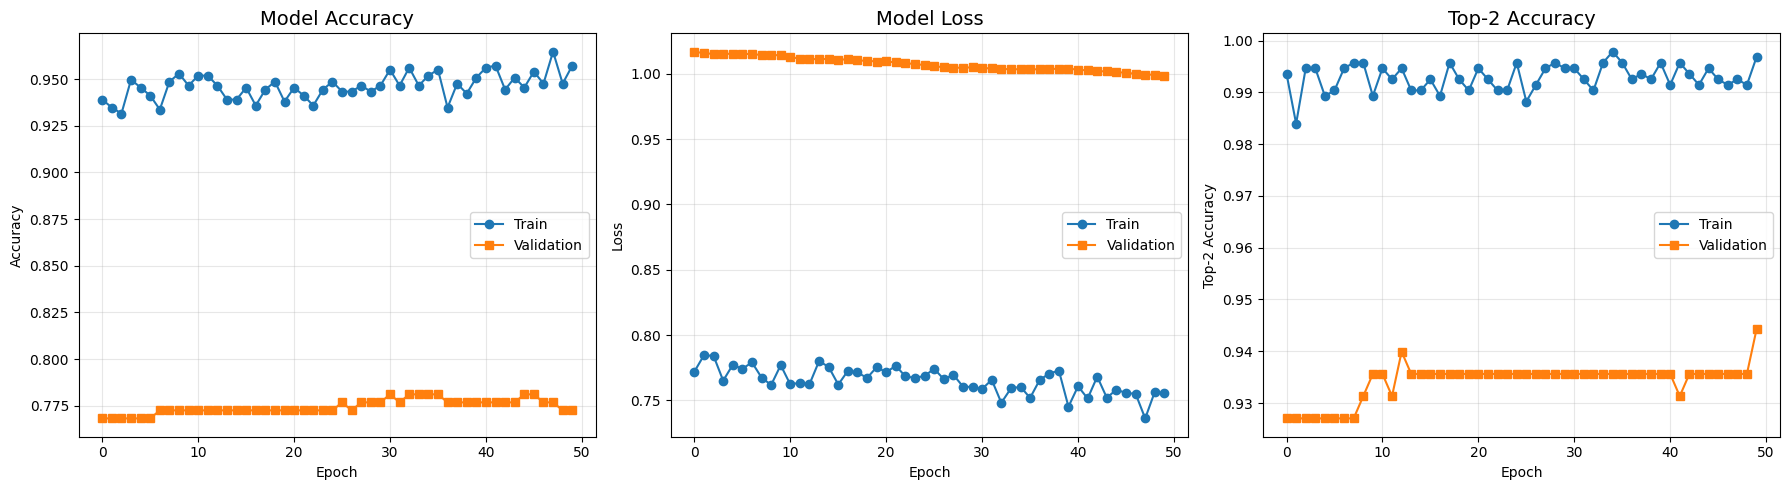


FINAL TRAINING METRICS
Final Train Accuracy: 0.9572 (95.72%)
Final Val Accuracy:   0.7725 (77.25%)
Best Val Accuracy:    0.7811 (78.11%)
Best Epoch:           31
Overfitting Gap:      0.1847 (18.47%)

❌ High overfitting - consider more regularization


In [21]:
# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Train', marker='o')
axes[0].plot(history.history['val_accuracy'], label='Validation', marker='s')
axes[0].set_title('Model Accuracy', fontsize=14)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history.history['loss'], label='Train', marker='o')
axes[1].plot(history.history['val_loss'], label='Validation', marker='s')
axes[1].set_title('Model Loss', fontsize=14)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Top-2 Accuracy
axes[2].plot(history.history['top2_accuracy'], label='Train', marker='o')
axes[2].plot(history.history['val_top2_accuracy'], label='Validation', marker='s')
axes[2].set_title('Top-2 Accuracy', fontsize=14)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Top-2 Accuracy')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print metrics
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
best_val_acc = max(history.history['val_accuracy'])
best_epoch = history.history['val_accuracy'].index(best_val_acc) + 1
overfitting_gap = abs(final_train_acc - final_val_acc)

print("\n" + "="*60)
print("FINAL TRAINING METRICS")
print("="*60)
print(f"Final Train Accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"Final Val Accuracy:   {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
print(f"Best Val Accuracy:    {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"Best Epoch:           {best_epoch}")
print(f"Overfitting Gap:      {overfitting_gap:.4f} ({overfitting_gap*100:.2f}%)")

if overfitting_gap < 0.05:
    print("\n✅ Excellent generalization!")
elif overfitting_gap < 0.10:
    print("\n✅ Good generalization")
elif overfitting_gap < 0.15:
    print("\n⚠️ Moderate overfitting")
else:
    print("\n❌ High overfitting - consider more regularization")

## 11. Load Best Model & Evaluate

In [22]:
# Load best model
best_model = tf.keras.models.load_model(f"{CONFIG['model_save_dir']}/best_model_v5.keras")
print("✅ Best model loaded")

# Evaluate
print("\nEvaluating on validation set...")
results = best_model.evaluate(val_ds, verbose=1)

print("\n" + "="*60)
print("BEST MODEL PERFORMANCE")
print("="*60)
print(f"Validation Loss:      {results[0]:.4f}")
print(f"Validation Accuracy:  {results[1]:.4f} ({results[1]*100:.2f}%)")
print(f"Validation Top-2 Acc: {results[2]:.4f} ({results[2]*100:.2f}%)")

✅ Best model loaded

Evaluating on validation set...
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 770ms/step - accuracy: 0.7886 - loss: 1.0194 - top2_accuracy: 0.9336

BEST MODEL PERFORMANCE
Validation Loss:      1.0043
Validation Accuracy:  0.7811 (78.11%)
Validation Top-2 Acc: 0.9356 (93.56%)


## 12. Detailed Evaluation

In [23]:
# Get predictions
print("Generating predictions...")

# Reload validation set for predictions
val_ds_eval = tf.keras.utils.image_dataset_from_directory(
    CONFIG['data_dir'],
    validation_split=CONFIG['validation_split'],
    subset="validation",
    seed=CONFIG['seed'],
    image_size=(CONFIG['img_height'], CONFIG['img_width']),
    batch_size=CONFIG['batch_size'],
    label_mode='int',
    shuffle=False
)

# Preprocess
val_ds_eval = val_ds_eval.map(
    lambda x, y: (preprocess_input(x), y),
    num_parallel_calls=AUTOTUNE
)

y_true = []
y_pred = []

for images, labels in val_ds_eval:
    predictions = best_model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

accuracy = np.mean(y_true == y_pred)
print(f"\n✅ Predictions generated")
print(f"Total: {len(y_pred)}")
print(f"Correct: {np.sum(y_true == y_pred)}")
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

Generating predictions...
Found 1168 files belonging to 4 classes.
Using 233 files for validation.

✅ Predictions generated
Total: 233
Correct: 218
Accuracy: 0.9356 (93.56%)


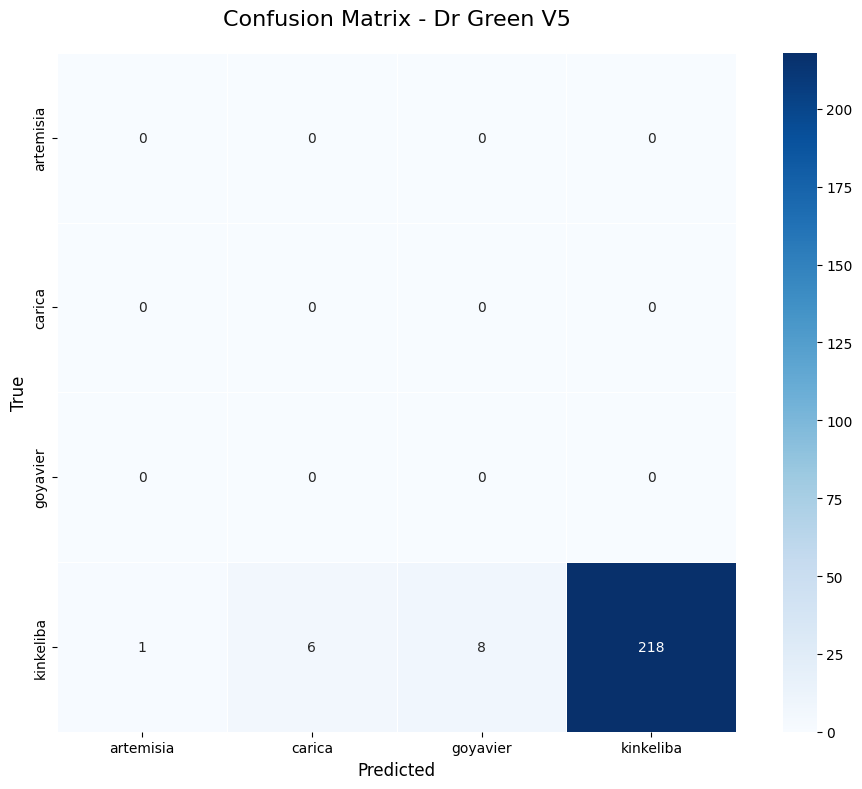


CLASSIFICATION REPORT
              precision    recall  f1-score   support

   artemisia     0.0000    0.0000    0.0000         0
      carica     0.0000    0.0000    0.0000         0
    goyavier     0.0000    0.0000    0.0000         0
   kinkeliba     1.0000    0.9356    0.9667       233

    accuracy                         0.9356       233
   macro avg     0.2500    0.2339    0.2417       233
weighted avg     1.0000    0.9356    0.9667       233


Per-class accuracy:
  ❌ artemisia   : nan (nan%)
  ❌ carica      : nan (nan%)
  ❌ goyavier    : nan (nan%)
  ✅ kinkeliba   : 0.9356 (93.56%)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-4245543436.py:28: RuntimeWarning: invalid value encoun

In [24]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    square=True,
    linewidths=0.5
)
plt.title('Confusion Matrix - Dr Green V5', fontsize=16, pad=20)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.tight_layout()
plt.show()

# Classification report
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Per-class accuracy
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

print("\nPer-class accuracy:")
for class_name, acc in zip(class_names, per_class_accuracy):
    emoji = "✅" if acc >= 0.80 else "⚠️" if acc >= 0.70 else "❌"
    print(f"  {emoji} {class_name:12s}: {acc:.4f} ({acc*100:.2f}%)")

## 13. Save Final Model

In [ ]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_name = f"drgreen_v5_optimized_{timestamp}"

print("\n" + "="*60)
print(f"SAVING MODEL: {model_name}")
print("="*60)

# 1. Keras format
keras_path = f"{CONFIG['model_save_dir']}/{model_name}.keras"
best_model.save(keras_path)
print(f"✓ Keras: {keras_path}")

# 2. TFLite (optimized for mobile)
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

tflite_path = f"{CONFIG['model_save_dir']}/{model_name}.tflite"
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)
print(f"✓ TFLite: {tflite_path}")

# 3. Metadata
metadata = {
    'model_name': model_name,
    'version': '5.0-optimized',
    'created_at': timestamp,
    'approach': 'Frozen EfficientNetB0 with strong regularization',
    'config': CONFIG,
    'class_names': class_names,
    'performance': {
        'val_accuracy': float(results[1]),
        'val_top2_accuracy': float(results[2]),
        'val_loss': float(results[0]),
        'best_val_accuracy': float(best_val_acc),
        'overfitting_gap': float(overfitting_gap)
    },
    'per_class_accuracy': {
        class_names[i]: float(per_class_accuracy[i])
        for i in range(len(class_names))
    }
}

metadata_path = f"{CONFIG['model_save_dir']}/{model_name}_metadata.json"
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✓ Metadata: {metadata_path}")

# 4. Class names
class_names_path = f"{CONFIG['model_save_dir']}/class_names.json"
with open(class_names_path, 'w') as f:
    json.dump(class_names, f, indent=2)
print(f"✓ Class names: {class_names_path}")

# File sizes
keras_size = os.path.getsize(keras_path) / (1024*1024)
tflite_size = os.path.getsize(tflite_path) / (1024*1024)
print(f"\nFile sizes:")
print(f"  Keras:  {keras_size:.2f} MB")
print(f"  TFLite: {tflite_size:.2f} MB")

## 14. Final Summary

In [ ]:
print("\n" + "="*60)
print("🌿 DR GREEN V5 - TRAINING COMPLETE")
print("="*60)

print(f"\n📊 Architecture:")
print(f"  Base: {CONFIG['base_model']} (FROZEN)")
print(f"  Parameters: {model.count_params():,}")
print(f"  Trainable: {trainable:,}")

print(f"\n🎯 Performance:")
print(f"  Validation Accuracy: {results[1]*100:.2f}%")
print(f"  Top-2 Accuracy:      {results[2]*100:.2f}%")
print(f"  Overfitting Gap:     {overfitting_gap*100:.2f}%")

print(f"\n🌱 Per-Class:")
for class_name, acc in zip(class_names, per_class_accuracy):
    emoji = "✅" if acc >= 0.80 else "⚠️" if acc >= 0.70 else "❌"
    print(f"  {emoji} {class_name}: {acc*100:.2f}%")

print(f"\n💾 Saved:")
print(f"  • {model_name}.keras")
print(f"  • {model_name}.tflite")

print("\n" + "="*60)
print("🚀 READY FOR DEPLOYMENT!")
print("="*60)

## 15. Download Models (Colab)

In [ ]:
# Download models from Colab
from google.colab import files

print("📥 Downloading models...")
print("\nClick the links below to download:")

# Download Keras model
files.download(keras_path)

# Download TFLite model
files.download(tflite_path)

# Download metadata
files.download(metadata_path)

# Download class names
files.download(class_names_path)

print("\n✅ Downloads initiated!")